In [1]:
import cv2 as cv 
import numpy as np

from Plot import plot_img

In [2]:
img1 = cv.imread("data/img1.png", cv.IMREAD_COLOR_RGB)
img2 = cv.imread("data/img2.png", cv.IMREAD_COLOR_RGB)
img1.shape, img2.shape

((926, 1504, 3), (926, 1504, 3))

In [3]:
gray1 = cv.cvtColor(img1, cv.COLOR_RGB2GRAY)
gray2 = cv.cvtColor(img2, cv.COLOR_RGB2GRAY)

In [4]:
sift = cv.SIFT_create()

kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

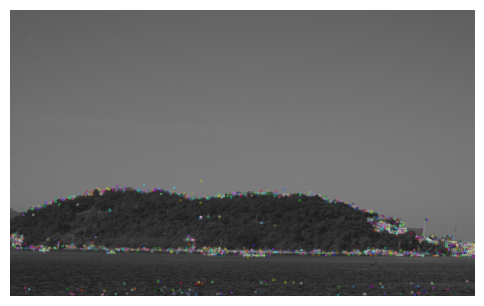

In [5]:
img = cv.drawKeypoints(gray1,kp1,img1)
plot_img(img)

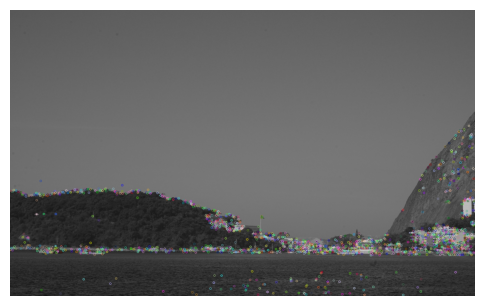

In [6]:
img2 = cv.drawKeypoints(gray2,kp2,img2)
plot_img(img2)

In [7]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)

In [8]:
matches = flann.knnMatch(des1, des2, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

In [9]:
if len(good_matches) > 10:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    H, mask = cv.findHomography(dst_pts, src_pts, cv.RANSAC, 5.0)

    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    pano_w = w1 + w2
    pano_h = max(h1, h2)

    panorama = cv.warpPerspective(img2, H, (pano_w, pano_h))
    panorama[0:h1, 0:w1] = img1
else:
    raise ValueError("There are not enough matches to create an mosaic")


In [10]:
gray_pano = cv.cvtColor(panorama, cv.COLOR_RGB2GRAY)
_, thresh = cv.threshold(gray_pano, 1, 255, cv.THRESH_BINARY)

contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
x, y, w, h = cv.boundingRect(max(contours, key=cv.contourArea))

panorama_cropped = panorama[y:y+h, x:x+w]

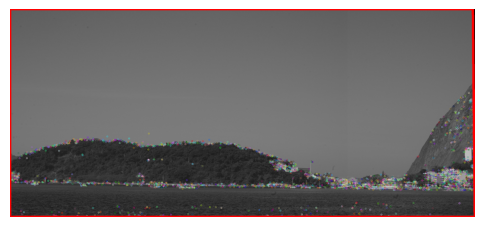

In [11]:
bbox = panorama_cropped.copy()

cv.drawContours(bbox, contours, -1, (255,0,), 10)
plot_img(bbox)

## Results

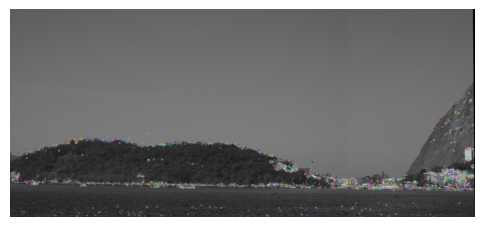

In [12]:
plot_img(panorama_cropped)